# Proyecto de la materia Procesamiento Embebido de Señales
## Segmentación de imágenes con OpenCV y SciKit-image
### Métodos de sementación de imágenes

![alt text](metodos_segmentacion.png "Metodos Segmentación")

El presente trabajo práctico tiene como objetivo la segmentación **no supervisada** de imagenes.

Para ello se cuentan con las siguientes etapas:
1. Preprocesamiento de la imagen
2. Visualización del histograma de la imagen (en RGB)
3. Método K-Means (OpenCV)
4. Método SLIC (Simple Linear Iterative Clustering)
    1. RAG con corte por umbral
    2. RAG con corte normalizado
    3. RAG con Merge
5. Método Felzenszwalb
    1. RAG con corte por umbral
    2. RAG con corte normalizado
    3. RAG con Merge
6. Contadores de segmentos únicos segun cada Método y su variante
7. Histograma de gradientes orientados
8. Etiquetado de contornos en base a segmentación realizada (Labeling)

Finalmente se comparará el algoritmo con una imagen ruidosa:
1. Agregación de ruido a la imagen original

Pendientes a implementar:
1. Hierarchical Merging of Region Boundary RAGs
2. Drawing Region Adjacency Graphs (RAGs)
3. Morphological Snakes
4. Entropía



### Método K-Means
Se caracteriza por buscar los centros de una cierta cantidad de clusters y agrupa las muestras de entrada en dichos clusters.

### Método SLIC (Simple Linear Iterative Clustering)
Se caracteriza por utilizar otro algoritmo de machine-learning denominado K-Means.
El mismo toma todos los valores de los pixeles de la imagen e intenta separarlos en una determinada cantidad de sub-regiones.
Toma la imagen a color (3 canales) por lo que se usará la imagen original

### Método Felzenszwalb


Nota: al método utilizado para segmentar se lo conoce como "over-segmentation" ya que corresponde a una primera aproximación de segmentación en un algoritmo real.

### RAG Thresholding
La técnica Region Adjacency Graph (RAG) realiza un merge de las regiones que tienen colores similares. Se construirá un RAG y se definirán bordes como la diferencia del promedio de colores. Luego se unirán las regiones que contengan un promedio de color similar (dependiendo el umbral de threshold).

## Fotos testeadas y comparadas con sus GroundTruths
- 8143.jpg
- 22013.jpg
- 35058.jpg
- 41004.jpg
- 56028.jpg
- 94079.jpg
- 314016.jpg

In [38]:
from __future__ import division
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
import imutils
import skimage.data as data
import skimage.exposure as exposure
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import skimage.feature as feature
import skimage.morphology as morph
import skimage.util as util
import skimage.future as future

def nothing(x):
    pass

# Parámetros de ajuste de los métodos de segmentación
TAMANIO_KERNEL_MEDIANA = 3
NUMERO_SEGMENTOS_SLIC = 400
NIVEL_COMPACT_SLIC = 10
SIGMA_SLIC = 1.0
UMBRAL_CORTE_SLIC = 29
UMBRAL_MERGE_SLIC = 35

MAX_SEGMENTOS_FELZENSZWALB = 300
ESCALA_FELZENSZWALB = 100
SIGMA_FELZENSZWALB = 0.5
TAMANIO_MIN_FELZENSZWALB = 50
UMBRAL_CORTE_FELZENSZWALB = 29
UMBRAL_MERGE_FELZENSZWALB = 35

#### Abrir la imagen desde el dataset ####
# Configurar imagen del dataset y su respectivo GroundTruth
ruta_img = 'imagenes/94079.jpg'
rutaGT_img = 'ground-truth/94079-1105.seg'

#### Funciones auxiliares para RAG con Merge ####
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])

#### Función que calcula el porcentaje de match entre 2 imagenes segmentadas ####    
def calcularPorcentaje(debug, seg, vector_img, segs_img, alto_img, largo_img):
    segmentos_gt_humano = np.zeros((alto_img,largo_img), np.uint8)
    for a in vector_img:
        for b in a:
            segmentos_gt_humano[b[1]][b[2]] = str(b[0])
    
    segmentos_a_evaluar = np.copy(seg)
    cant_segs = np.unique(segmentos_a_evaluar).size
    cant_segs_humano = segs_img
    tabla_match = np.zeros((cant_segs,cant_segs_humano), np.uint32)
    array_segs_humano = []
    array_segs = []
    for a in range(alto_img):
        for b in range(largo_img):
            seg_aux = segmentos_a_evaluar[a][b]
            seg_aux_humano = segmentos_gt_humano[a][b]
            if (seg_aux not in array_segs):
                array_segs.append(seg_aux)
            if (seg_aux_humano not in array_segs_humano):
                array_segs_humano.append(seg_aux_humano)
            indice_aux = array_segs.index(seg_aux)
            indice_aux_humano = array_segs_humano.index(seg_aux_humano)

            tabla_match[indice_aux][indice_aux_humano] += 1

    array_suma = np.zeros((cant_segs_humano), np.uint32)
    for a in range(cant_segs):
        for b in range(cant_segs_humano):
            array_suma[b] += tabla_match[a][b]

    # Se arma la tabla con porcentajes
    tabla_porc = np.zeros((cant_segs,cant_segs_humano), np.float32)
    for a in range(cant_segs):
        for b in range(cant_segs_humano):
            if (array_suma[b] == 0):
                tabla_porc[a][b] = None
            else:
                tabla_porc[a][b] = tabla_match[a][b]/array_suma[b]
                
    # Se calculan los mayores porcentajes excluyendo los elegidos y se los promedia
    sum_porc = 0
    prom_porc = 0
    maximo = 0
    indice_max = -1
    indices_tomados = []
    for b in range(cant_segs_humano):
        if (np.isnan(tabla_porc[0][b])):
            continue
        for a in range(cant_segs):
            if (a not in indices_tomados):
                if (tabla_porc[a][b] > maximo):
                    maximo = tabla_porc[a][b]
                    indice_max = a
                    #print("maximo: {}".format(maximo))
        sum_porc += maximo
        #print("suma: {}".format(sum_porc))
        indices_tomados.append(indice_max)
        maximo = 0
        indice_max = -1
    prom_porc = sum_porc / len(indices_tomados)
    if (debug):
        print("\narray_segs: \n{}".format(array_segs))
        print("\narray_segs_humano: \n{}".format(array_segs_humano))
        print("\ntabla_match: \n{}".format(tabla_match))
        print("\narray_suma: \n{}".format(array_suma))
        print("\ntabla_porc: \n{}".format(tabla_porc))
        print("\nsum_porc: \n{}".format(sum_porc))
        print("\nlen(indices_tomados): \n{}".format(len(indices_tomados)))
    return prom_porc

    
#### Funcion de segmentación y comparación contra un GroundTruth elegido ####
def segmentarDiversosMetodosYComparar(ruta_img,
                                      rutaGT_img,
                                      debug = 0,
                                      TAMANIO_KERNEL_MEDIANA=3,
                                      NUMERO_SEGMENTOS_SLIC=400,
                                      NIVEL_COMPACT_SLIC=10,
                                      SIGMA_SLIC=1.0,
                                      UMBRAL_CORTE_SLIC=29,
                                      UMBRAL_MERGE_SLIC=35,
                                      MAX_SEGMENTOS_FELZENSZWALB=300,
                                      ESCALA_FELZENSZWALB=100,
                                      SIGMA_FELZENSZWALB=0.5,
                                      TAMANIO_MIN_FELZENSZWALB=50,
                                      UMBRAL_CORTE_FELZENSZWALB=29,
                                      UMBRAL_MERGE_FELZENSZWALB=35):
    # Importar imagen del dataset
    imagen = cv2.imread(ruta_img,1)
    # Transformar la imagen BRG a HSV y RGB
    imagen = cv2.cvtColor(imagen, cv2.cv.CV_BGR2HSV)
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_HSV2RGB)

    #### Preprocesamiento de la imagen ####
    # Se aplica un filtro de mediana con kernel de tamaño 3
    mediana_filtrada = scipy.ndimage.median_filter(imagen_rgb, size=TAMANIO_KERNEL_MEDIANA)

    #### Método K-Means (OpenCV) ####
    Z = imagen.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 4
    ret,segmentos_kmeans,center = cv2.kmeans(Z, K, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[segmentos_kmeans.flatten()]
    res2 = res.reshape((imagen.shape))

    #### Método SLIC (Simple Linear Iterative Clustering) ####
    segmentos_slic = seg.slic(mediana_filtrada,n_segments=NUMERO_SEGMENTOS_SLIC, compactness=NIVEL_COMPACT_SLIC, sigma=SIGMA_SLIC)
    # CON 155 segmentos el RAG QUEDABA MAL, con 400 quedo casi impecable

    #### RAG (Region Adjacency Graph) para Método SLIC con corte por umbral (cut threshold) ####
    g = future.graph.rag_mean_color(imagen_rgb, segmentos_slic)
    segmentos_rag_slic = future.graph.cut_threshold(segmentos_slic, g, UMBRAL_CORTE_SLIC)
    out2 = color.label2rgb(segmentos_rag_slic, imagen_rgb, kind='avg')

    #### RAG para Método SLIC con corte normalizado (normalized cut) ####
    g = future.graph.rag_mean_color(imagen_rgb, segmentos_slic, mode='similarity')
    segmentos_rag_slic_normalizado = future.graph.cut_normalized(segmentos_slic, g)
    out2 = color.label2rgb(segmentos_rag_slic_normalizado, imagen_rgb, kind='avg')

    #### RAG para Método SLIC con merge ####
    g = future.graph.rag_mean_color(imagen_rgb, segmentos_slic)
    segmentos_slic_merge = future.graph.merge_hierarchical(segmentos_slic, g,
                                                thresh=UMBRAL_MERGE_SLIC, rag_copy=False,
                                                in_place_merge=True,
                                                merge_func=merge_mean_color,
                                                weight_func=_weight_mean_color)

    #### Método Felzenszwalb ####
    segmentos_felzenszwalb = seg.felzenszwalb(mediana_filtrada, scale=ESCALA_FELZENSZWALB, sigma=SIGMA_FELZENSZWALB, min_size=TAMANIO_MIN_FELZENSZWALB) 
    MIN_SIZE = TAMANIO_MIN_FELZENSZWALB
    print("Cant. segs. Metodo Felzenszwalb: {}".format(np.unique(segmentos_felzenszwalb).size))
    # este while es un workaround porque este metodo puede traer muchos segmentos
    # y al hacerlo, da un overflow de iteraciones en el normalized cut
    # Para mayor detalle el error es
    # ArpackNoConvergence: ARPACK error -1: No convergence (7771 iterations, 83/100 eigenvectors converged)
    # por lo que, de manera empirica, lo limito actualmente a 299 segmentos
    while(np.unique(segmentos_felzenszwalb).size >= MAX_SEGMENTOS_FELZENSZWALB):
        MIN_SIZE=MIN_SIZE+25
        segmentos_felzenszwalb = seg.felzenszwalb(mediana_filtrada, scale=ESCALA_FELZENSZWALB, sigma=SIGMA_FELZENSZWALB, min_size=MIN_SIZE) 
        print("Cant. segs. Metodo Felzenszwalb: {}".format(np.unique(segmentos_felzenszwalb).size))

    #### RAG para Método Felzenszwalb con corte por umbral ####
    g = future.graph.rag_mean_color(imagen_rgb, segmentos_felzenszwalb)
    segmentos_rag_felzenszwalb = future.graph.cut_threshold(segmentos_felzenszwalb, g, UMBRAL_CORTE_FELZENSZWALB)
    out2 = color.label2rgb(segmentos_rag_felzenszwalb, imagen_rgb, kind='avg')

    #### RAG para Método Felzenszwalb con corte normalizado ####
    g = future.graph.rag_mean_color(imagen_rgb, segmentos_felzenszwalb, mode='similarity')
    segmentos_rag_felzenszwalb_normalizado = future.graph.cut_normalized(segmentos_felzenszwalb, g)
    out2 = color.label2rgb(segmentos_rag_felzenszwalb_normalizado, imagen_rgb, kind='avg')

    #### RAG para Método Felzenszwalb con merge ####
    g = future.graph.rag_mean_color(imagen_rgb, segmentos_felzenszwalb)
    segmentos_felzenszwalb_merge = future.graph.merge_hierarchical(segmentos_felzenszwalb, g,
                                            thresh=UMBRAL_MERGE_FELZENSZWALB, rag_copy=False,
                                            in_place_merge=True,
                                            merge_func=merge_mean_color,
                                            weight_func=_weight_mean_color)

    if(debug):
        ### Contadores de segmentos únicos segun cada método con su variante
        print("Cantidad de segmentos diferenciados por metodo")
        print("K-Means (OpenCV): {}".format(np.unique(segmentos_kmeans).size))
        print("SLIC: {}".format(np.unique(segmentos_slic).size))
        print("Felzenszwalb: {}".format(np.unique(segmentos_felzenszwalb).size))

        print("RAG SLIC con corte por umbral: {} ".format(np.unique(segmentos_rag_slic).size))
        print("RAG SLIC con corte normalizado: {} ".format(np.unique(segmentos_rag_slic_normalizado).size))
        print("RAG SLIC con Merge: {} ".format(np.unique(segmentos_slic_merge).size))

        print("RAG Felzenszwalb con corte por umbral: {} ".format(np.unique(segmentos_rag_felzenszwalb).size))
        print("RAG Felzenszwalb con corte normalizado: {} ".format(np.unique(segmentos_rag_felzenszwalb_normalizado).size))
        print("RAG Felzenszwalb con Merge: {} ".format(np.unique(segmentos_felzenszwalb_merge).size))

    #### Comparación con Ground Truth ####
    # Se compara con el .segment del ground truth
    # el mismo se compone de una segmentacion humana

    # La función de comparación se basa en:
    #######################################################################
    # Generar una tabla que refleje en sus filas los segmentos calculados
    # y en sus columnas los segmentos ground-truth
    # Adicionalmente se generara otra tabla con los porcentajes de matcheo
    # entre el segmento de la fila (calculado) y el segmento del ground-truth
    #        Seg1            Seg2           Seg3     Total
    #Seg1     02             25             00         27
    #Seg2    120             01             00        121
    #Total   122             26             00        148

    #         Seg1            Seg2           Seg3
    #%Seg1  2/122=0,01%    25/27=92%         NULL => es NULL porque el total es 0
    #%Seg2  120/122=98%    1/27=3,7%         NULL => sino sería el % que da la cuenta

    # Finalmente hay que tomar el mayor porcentaje de la tabla
    # y separarlo a la vez que "cancelamos" esa fila y columna
    # luego iterar el procedimiento sumando dicho % al anterior
    # cancelar esa fila y esa columna
    # iterar hasta que no queden filas o columnas
    # finalizar realizando un promedio de dichos porcentajes
    # ese número final será el identificador del
    # segmento calculado para el ground-truth elegido
    # debera repetirse dicho procedimiento para todos los ground-truth
    # y tomar un promedio total de todos los números (promedios) de match

    # opcional 1°:
    # se podría realizar el mismo procedimiento pero a la inversa
    # tomando los menores porcentajes de la tabla
    # lo que no se es que significaría dicho número
    # opcional 2°:
    # se podría adicionar un número que compare la cantidad de segmentos
    # pero, en ppio, dicho número casi siempre daría bajo
    #######################################################################
    
    # Lectura del encabezado
    estado = 0
    header = 1
    vector_img = []
    segmento_img = []
    fila_img = []
    columna_img = []
    with open(
        rutaGT_img
        ) as fseg_humano:
        for linea in fseg_humano:
            linea = linea.replace('\n','')
            a = linea.split(' ')
            if header == 1:
                if (a[0] == 'width'):
                    largo_img = int(a[1])
                if (a[0] == 'height'):
                    alto_img = int(a[1])
                if (a[0] == 'segments'):
                    segs_img = int(a[1])
                if (a[0] == 'data'):
                    #segmentos = np.empty((segs_img, largo_img, alto_img), np.uint16)
                    header = 0
            else:
                # lectura de los segmentos
                vector_img.append([[int(a[0]), int(a[1]), c] for c in np.arange(
                        int(a[2]),
                        int(a[3])
                        )])
                # 
                for c in np.arange(int(a[2]),int(a[3])):
                    segmento_img.append(int(a[0]))
                    fila_img.append(int(a[1]))
                    columna_img.append(c)

    ### Se itera sobre cada segmento a evaluar
    #segmentos_a_evaluar = np.copy(segmentos_slic) #=> prom_porc: 0.25..
    #segmentos_a_evaluar = np.copy(segmentos_rag_slic) #=> prom_porc: 0.34..
    #segmentos_a_evaluar = np.copy(segmentos_rag_slic_normalizado) #=> prom_porc: 0.41..
    #segmentos_a_evaluar = np.copy(segmentos_slic_merge) #=> prom_porc: 0.32..
    #segmentos_a_evaluar = np.copy(segmentos_felzenszwalb) #=> prom_porc: 0.37
    #segmentos_a_evaluar = np.copy(segmentos_rag_felzenszwalb) #=> prom_porc: 0.38
    #segmentos_a_evaluar = np.copy(segmentos_rag_felzenszwalb_normalizado) #=> prom_porc: 0.34
    #segmentos_a_evaluar = np.copy(segmentos_felzenszwalb_merge) #=> prom_porc: 0.3
    #
    # para testear la funcion
    #segmentos_a_evaluar = np.copy(segmentos_gt_humano) #=> prom_porc: 1.0
    match_slic = round(100*calcularPorcentaje(
            debug,
            segmentos_slic,
            vector_img, segs_img, alto_img, largo_img),1)
    print("\n% Match SLIC: {}%".format(
        match_slic))
    
    match_rag_slic_umbral = round(100*calcularPorcentaje(
            debug,
            segmentos_rag_slic,
            vector_img, segs_img, alto_img, largo_img),1)
    print("\n% Match RAG SLIC con corte por umbral: {}%".format(
        match_rag_slic_umbral))
    
    match_rag_slic_normalizado = round(100*calcularPorcentaje(
            debug,
            segmentos_rag_slic_normalizado,
            vector_img, segs_img, alto_img, largo_img),1)
    print("\n% Match RAG SLIC con corte normalizado: {}%".format(
        match_rag_slic_normalizado))
    
    match_rag_slic_merge = round(100*calcularPorcentaje(
            debug,
            segmentos_slic_merge,
            vector_img, segs_img, alto_img, largo_img),1)
    print("\n% Match RAG SLIC con merge: {}%".format(
        match_rag_slic_merge))
    
    match_felzenszwalb = round(100*calcularPorcentaje(
            debug,
            segmentos_felzenszwalb,
            vector_img, segs_img, alto_img, largo_img),1)
    print("\n% Match Felzenszwalb: {}%".format(
        match_felzenszwalb))
    
    match_rag_felzenszwalb_umbral = round(100*calcularPorcentaje(
            debug,
            segmentos_rag_felzenszwalb,
            vector_img, segs_img, alto_img, largo_img),1)
    print("\n% Match RAG Felzenszwalb con corte por umbral: {}%".format(
        match_rag_felzenszwalb_umbral))
    
    match_rag_felzenszwalb_normalizado = round(100*calcularPorcentaje(
            debug,
            segmentos_rag_felzenszwalb_normalizado,
            vector_img, segs_img, alto_img, largo_img),1)
    print("\n% Match RAG Felzenszwalb con corte normalizado: {}%".format(
        match_rag_felzenszwalb_normalizado))
    
    match_rag_felzenszwalb_merge = round(100*calcularPorcentaje(
            debug,
            segmentos_felzenszwalb_merge,
            vector_img, segs_img, alto_img, largo_img),1)
    print("\n% Match RAG Felzenszwalb con merge: {}%".format(
        match_rag_felzenszwalb_merge))

    print("\nResultado normalizado: {},{},{},{},{},{},{},{}".format(
          match_slic,
          match_rag_slic_umbral,
          match_rag_slic_normalizado,
          match_rag_slic_merge,
          match_felzenszwalb,
          match_rag_felzenszwalb_umbral,
          match_rag_felzenszwalb_normalizado,
          match_rag_felzenszwalb_merge))
    
    return
    

In [44]:
ruta_img = 'imagenes/8143.jpg'
rutaGT_img = 'ground-truth/8143-1107.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 777
Cant. segs. Metodo Felzenszwalb: 548
Cant. segs. Metodo Felzenszwalb: 415
Cant. segs. Metodo Felzenszwalb: 352
Cant. segs. Metodo Felzenszwalb: 299

% Match SLIC: 44.7%

% Match RAG SLIC con corte por umbral: 44.9%

% Match RAG SLIC con corte normalizado: 41.2%

% Match RAG SLIC con merge: 37.6%

% Match Felzenszwalb: 57.0%

% Match RAG Felzenszwalb con corte por umbral: 47.6%

% Match RAG Felzenszwalb con corte normalizado: 43.7%

% Match RAG Felzenszwalb con merge: 43.9%

Resultado normalizado: 44.7,44.9,41.2,37.6,57.0,47.6,43.7,43.9


In [45]:
ruta_img = 'imagenes/8143.jpg'
rutaGT_img = 'ground-truth/8143-1123.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 777
Cant. segs. Metodo Felzenszwalb: 548
Cant. segs. Metodo Felzenszwalb: 415
Cant. segs. Metodo Felzenszwalb: 352
Cant. segs. Metodo Felzenszwalb: 299

% Match SLIC: 46.6%

% Match RAG SLIC con corte por umbral: 54.9%

% Match RAG SLIC con corte normalizado: 50.6%

% Match RAG SLIC con merge: 44.2%

% Match Felzenszwalb: 46.4%

% Match RAG Felzenszwalb con corte por umbral: 36.9%

% Match RAG Felzenszwalb con corte normalizado: 33.8%

% Match RAG Felzenszwalb con merge: 46.7%

Resultado normalizado: 46.6,54.9,50.6,44.2,46.4,36.9,33.8,46.7


In [51]:
ruta_img = 'imagenes/22013.jpg'
rutaGT_img = 'ground-truth/22013-1105.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 357
Cant. segs. Metodo Felzenszwalb: 269

% Match SLIC: 2.5%

% Match RAG SLIC con corte por umbral: 54.5%

% Match RAG SLIC con corte normalizado: 60.3%

% Match RAG SLIC con merge: 43.2%

% Match Felzenszwalb: 25.7%

% Match RAG Felzenszwalb con corte por umbral: 55.8%

% Match RAG Felzenszwalb con corte normalizado: 61.0%

% Match RAG Felzenszwalb con merge: 51.6%

Resultado normalizado: 2.5,54.5,60.3,43.2,25.7,55.8,61.0,51.6


In [52]:
ruta_img = 'imagenes/22013.jpg'
rutaGT_img = 'ground-truth/22013-1108.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 357
Cant. segs. Metodo Felzenszwalb: 269

% Match SLIC: 59.4%

% Match RAG SLIC con corte por umbral: 14.9%

% Match RAG SLIC con corte normalizado: 11.8%

% Match RAG SLIC con merge: 17.1%

% Match Felzenszwalb: 29.8%

% Match RAG Felzenszwalb con corte por umbral: 17.4%

% Match RAG Felzenszwalb con corte normalizado: 16.5%

% Match RAG Felzenszwalb con merge: 16.9%

Resultado normalizado: 59.4,14.9,11.8,17.1,29.8,17.4,16.5,16.9


In [53]:
ruta_img = 'imagenes/22013.jpg'
rutaGT_img = 'ground-truth/22013-1109.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 357
Cant. segs. Metodo Felzenszwalb: 269

% Match SLIC: 49.3%

% Match RAG SLIC con corte por umbral: 12.8%

% Match RAG SLIC con corte normalizado: 13.5%

% Match RAG SLIC con merge: 14.8%

% Match Felzenszwalb: 24.7%

% Match RAG Felzenszwalb con corte por umbral: 19.1%

% Match RAG Felzenszwalb con corte normalizado: 19.9%

% Match RAG Felzenszwalb con merge: 18.5%

Resultado normalizado: 49.3,12.8,13.5,14.8,24.7,19.1,19.9,18.5


In [54]:
ruta_img = 'imagenes/22013.jpg'
rutaGT_img = 'ground-truth/22013-1113.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 357
Cant. segs. Metodo Felzenszwalb: 269

% Match SLIC: 27.1%

% Match RAG SLIC con corte por umbral: 28.9%

% Match RAG SLIC con corte normalizado: 31.0%

% Match RAG SLIC con merge: 25.9%

% Match Felzenszwalb: 54.5%

% Match RAG Felzenszwalb con corte por umbral: 37.9%

% Match RAG Felzenszwalb con corte normalizado: 38.5%

% Match RAG Felzenszwalb con merge: 42.7%

Resultado normalizado: 27.1,28.9,31.0,25.9,54.5,37.9,38.5,42.7


In [55]:
ruta_img = 'imagenes/22013.jpg'
rutaGT_img = 'ground-truth/22013-1123.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 357
Cant. segs. Metodo Felzenszwalb: 269

% Match SLIC: 26.8%

% Match RAG SLIC con corte por umbral: 24.7%

% Match RAG SLIC con corte normalizado: 16.9%

% Match RAG SLIC con merge: 19.6%

% Match Felzenszwalb: 48.1%

% Match RAG Felzenszwalb con corte por umbral: 37.6%

% Match RAG Felzenszwalb con corte normalizado: 23.3%

% Match RAG Felzenszwalb con merge: 27.3%

Resultado normalizado: 26.8,24.7,16.9,19.6,48.1,37.6,23.3,27.3


In [61]:
ruta_img = 'imagenes/35058.jpg'
rutaGT_img = 'ground-truth/35058-1105.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 140

% Match SLIC: 11.7%

% Match RAG SLIC con corte por umbral: 18.5%

% Match RAG SLIC con corte normalizado: 29.5%

% Match RAG SLIC con merge: 21.2%

% Match Felzenszwalb: 60.8%

% Match RAG Felzenszwalb con corte por umbral: 19.3%

% Match RAG Felzenszwalb con corte normalizado: 20.7%

% Match RAG Felzenszwalb con merge: 15.6%

Resultado normalizado: 11.7,18.5,29.5,21.2,60.8,19.3,20.7,15.6


In [62]:
ruta_img = 'imagenes/35058.jpg'
rutaGT_img = 'ground-truth/35058-1107.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 140

% Match SLIC: 20.4%

% Match RAG SLIC con corte por umbral: 12.1%

% Match RAG SLIC con corte normalizado: 21.1%

% Match RAG SLIC con merge: 11.4%

% Match Felzenszwalb: 41.4%

% Match RAG Felzenszwalb con corte por umbral: 12.7%

% Match RAG Felzenszwalb con corte normalizado: 13.5%

% Match RAG Felzenszwalb con merge: 10.0%

Resultado normalizado: 20.4,12.1,21.1,11.4,41.4,12.7,13.5,10.0


In [63]:
ruta_img = 'imagenes/35058.jpg'
rutaGT_img = 'ground-truth/35058-1108.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 140

% Match SLIC: 16.6%

% Match RAG SLIC con corte por umbral: 14.8%

% Match RAG SLIC con corte normalizado: 26.1%

% Match RAG SLIC con merge: 26.3%

% Match Felzenszwalb: 53.7%

% Match RAG Felzenszwalb con corte por umbral: 15.0%

% Match RAG Felzenszwalb con corte normalizado: 15.4%

% Match RAG Felzenszwalb con merge: 22.5%

Resultado normalizado: 16.6,14.8,26.1,26.3,53.7,15.0,15.4,22.5


In [64]:
ruta_img = 'imagenes/35058.jpg'
rutaGT_img = 'ground-truth/35058-1112.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 140

% Match SLIC: 12.7%

% Match RAG SLIC con corte por umbral: 16.6%

% Match RAG SLIC con corte normalizado: 29.3%

% Match RAG SLIC con merge: 19.4%

% Match Felzenszwalb: 58.3%

% Match RAG Felzenszwalb con corte por umbral: 16.4%

% Match RAG Felzenszwalb con corte normalizado: 17.5%

% Match RAG Felzenszwalb con merge: 13.0%

Resultado normalizado: 12.7,16.6,29.3,19.4,58.3,16.4,17.5,13.0


In [65]:
ruta_img = 'imagenes/35058.jpg'
rutaGT_img = 'ground-truth/35058-1132.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 140

% Match SLIC: 31.6%

% Match RAG SLIC con corte por umbral: 13.1%

% Match RAG SLIC con corte normalizado: 14.2%

% Match RAG SLIC con merge: 32.9%

% Match Felzenszwalb: 64.2%

% Match RAG Felzenszwalb con corte por umbral: 25.7%

% Match RAG Felzenszwalb con corte normalizado: 26.5%

% Match RAG Felzenszwalb con merge: 27.7%

Resultado normalizado: 31.6,13.1,14.2,32.9,64.2,25.7,26.5,27.7


In [56]:
ruta_img = 'imagenes/41004.jpg'
rutaGT_img = 'ground-truth/41004-1105.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 169

% Match SLIC: 15.3%

% Match RAG SLIC con corte por umbral: 33.9%

% Match RAG SLIC con corte normalizado: 26.4%

% Match RAG SLIC con merge: 32.0%

% Match Felzenszwalb: 73.7%

% Match RAG Felzenszwalb con corte por umbral: 32.7%

% Match RAG Felzenszwalb con corte normalizado: 16.8%

% Match RAG Felzenszwalb con merge: 59.5%

Resultado normalizado: 15.3,33.9,26.4,32.0,73.7,32.7,16.8,59.5


In [57]:
ruta_img = 'imagenes/41004.jpg'
rutaGT_img = 'ground-truth/41004-1107.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 169

% Match SLIC: 34.7%

% Match RAG SLIC con corte por umbral: 68.0%

% Match RAG SLIC con corte normalizado: 51.5%

% Match RAG SLIC con merge: 82.9%

% Match Felzenszwalb: 71.3%

% Match RAG Felzenszwalb con corte por umbral: 43.9%

% Match RAG Felzenszwalb con corte normalizado: 11.2%

% Match RAG Felzenszwalb con merge: 63.9%

Resultado normalizado: 34.7,68.0,51.5,82.9,71.3,43.9,11.2,63.9


In [58]:
ruta_img = 'imagenes/41004.jpg'
rutaGT_img = 'ground-truth/41004-1108.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 169

% Match SLIC: 1.6%

% Match RAG SLIC con corte por umbral: 58.8%

% Match RAG SLIC con corte normalizado: 53.0%

% Match RAG SLIC con merge: 54.4%

% Match Felzenszwalb: 50.7%

% Match RAG Felzenszwalb con corte por umbral: 34.6%

% Match RAG Felzenszwalb con corte normalizado: 33.5%

% Match RAG Felzenszwalb con merge: 54.2%

Resultado normalizado: 1.6,58.8,53.0,54.4,50.7,34.6,33.5,54.2


In [59]:
ruta_img = 'imagenes/41004.jpg'
rutaGT_img = 'ground-truth/41004-1112.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 169

% Match SLIC: 50.5%

% Match RAG SLIC con corte por umbral: 47.0%

% Match RAG SLIC con corte normalizado: 19.9%

% Match RAG SLIC con merge: 33.0%

% Match Felzenszwalb: 67.1%

% Match RAG Felzenszwalb con corte por umbral: 25.8%

% Match RAG Felzenszwalb con corte normalizado: 12.6%

% Match RAG Felzenszwalb con merge: 33.3%

Resultado normalizado: 50.5,47.0,19.9,33.0,67.1,25.8,12.6,33.3


In [60]:
ruta_img = 'imagenes/41004.jpg'
rutaGT_img = 'ground-truth/41004-1124.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 169

% Match SLIC: 35.3%

% Match RAG SLIC con corte por umbral: 16.7%

% Match RAG SLIC con corte normalizado: 12.3%

% Match RAG SLIC con merge: 17.3%

% Match Felzenszwalb: 43.3%

% Match RAG Felzenszwalb con corte por umbral: 13.7%

% Match RAG Felzenszwalb con corte normalizado: 10.3%

% Match RAG Felzenszwalb con merge: 17.8%

Resultado normalizado: 35.3,16.7,12.3,17.3,43.3,13.7,10.3,17.8


In [46]:
ruta_img = 'imagenes/56028.jpg'
rutaGT_img = 'ground-truth/56028-1105.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 442
Cant. segs. Metodo Felzenszwalb: 327
Cant. segs. Metodo Felzenszwalb: 272

% Match SLIC: 23.8%

% Match RAG SLIC con corte por umbral: 64.4%

% Match RAG SLIC con corte normalizado: 63.4%

% Match RAG SLIC con merge: 55.2%

% Match Felzenszwalb: 35.6%

% Match RAG Felzenszwalb con corte por umbral: 44.2%

% Match RAG Felzenszwalb con corte normalizado: 49.2%

% Match RAG Felzenszwalb con merge: 41.7%

Resultado normalizado: 23.8,64.4,63.4,55.2,35.6,44.2,49.2,41.7


In [47]:
ruta_img = 'imagenes/56028.jpg'
rutaGT_img = 'ground-truth/56028-1109.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 442
Cant. segs. Metodo Felzenszwalb: 327
Cant. segs. Metodo Felzenszwalb: 272

% Match SLIC: 23.4%

% Match RAG SLIC con corte por umbral: 58.6%

% Match RAG SLIC con corte normalizado: 66.2%

% Match RAG SLIC con merge: 53.9%

% Match Felzenszwalb: 33.6%

% Match RAG Felzenszwalb con corte por umbral: 49.3%

% Match RAG Felzenszwalb con corte normalizado: 57.5%

% Match RAG Felzenszwalb con merge: 47.5%

Resultado normalizado: 23.4,58.6,66.2,53.9,33.6,49.3,57.5,47.5


In [48]:
ruta_img = 'imagenes/56028.jpg'
rutaGT_img = 'ground-truth/56028-1119.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 442
Cant. segs. Metodo Felzenszwalb: 327
Cant. segs. Metodo Felzenszwalb: 272

% Match SLIC: 26.3%

% Match RAG SLIC con corte por umbral: 41.6%

% Match RAG SLIC con corte normalizado: 39.5%

% Match RAG SLIC con merge: 48.0%

% Match Felzenszwalb: 41.5%

% Match RAG Felzenszwalb con corte por umbral: 38.2%

% Match RAG Felzenszwalb con corte normalizado: 36.0%

% Match RAG Felzenszwalb con merge: 40.5%

Resultado normalizado: 26.3,41.6,39.5,48.0,41.5,38.2,36.0,40.5


In [49]:
ruta_img = 'imagenes/56028.jpg'
rutaGT_img = 'ground-truth/56028-1123.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 442
Cant. segs. Metodo Felzenszwalb: 327
Cant. segs. Metodo Felzenszwalb: 272

% Match SLIC: 18.7%

% Match RAG SLIC con corte por umbral: 41.1%

% Match RAG SLIC con corte normalizado: 38.6%

% Match RAG SLIC con merge: 43.3%

% Match Felzenszwalb: 27.8%

% Match RAG Felzenszwalb con corte por umbral: 48.5%

% Match RAG Felzenszwalb con corte normalizado: 51.8%

% Match RAG Felzenszwalb con merge: 46.9%

Resultado normalizado: 18.7,41.1,38.6,43.3,27.8,48.5,51.8,46.9


In [50]:
ruta_img = 'imagenes/56028.jpg'
rutaGT_img = 'ground-truth/56028-1130.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 442
Cant. segs. Metodo Felzenszwalb: 327
Cant. segs. Metodo Felzenszwalb: 272

% Match SLIC: 29.1%

% Match RAG SLIC con corte por umbral: 24.4%

% Match RAG SLIC con corte normalizado: 15.1%

% Match RAG SLIC con merge: 22.5%

% Match Felzenszwalb: 44.5%

% Match RAG Felzenszwalb con corte por umbral: 22.6%

% Match RAG Felzenszwalb con corte normalizado: 12.8%

% Match RAG Felzenszwalb con merge: 23.1%

Resultado normalizado: 29.1,24.4,15.1,22.5,44.5,22.6,12.8,23.1


In [39]:
ruta_img = 'imagenes/94079.jpg'
rutaGT_img = 'ground-truth/94079-1105.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 411
Cant. segs. Metodo Felzenszwalb: 316
Cant. segs. Metodo Felzenszwalb: 242

% Match SLIC: 24.6%

% Match RAG SLIC con corte por umbral: 34.3%

% Match RAG SLIC con corte normalizado: 41.6%

% Match RAG SLIC con merge: 31.8%

% Match Felzenszwalb: 39.4%

% Match RAG Felzenszwalb con corte por umbral: 39.8%

% Match RAG Felzenszwalb con corte normalizado: 34.9%

% Match RAG Felzenszwalb con merge: 31.1%

Resultado normalizado: 24.6,34.3,41.6,31.8,39.4,39.8,34.9,31.1


In [40]:
ruta_img = 'imagenes/94079.jpg'
rutaGT_img = 'ground-truth/94079-1109.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 411
Cant. segs. Metodo Felzenszwalb: 316
Cant. segs. Metodo Felzenszwalb: 242

% Match SLIC: 18.5%

% Match RAG SLIC con corte por umbral: 34.7%

% Match RAG SLIC con corte normalizado: 41.8%

% Match RAG SLIC con merge: 42.7%

% Match Felzenszwalb: 44.7%

% Match RAG Felzenszwalb con corte por umbral: 40.1%

% Match RAG Felzenszwalb con corte normalizado: 35.0%

% Match RAG Felzenszwalb con merge: 31.1%

Resultado normalizado: 18.5,34.7,41.8,42.7,44.7,40.1,35.0,31.1


In [41]:
ruta_img = 'imagenes/94079.jpg'
rutaGT_img = 'ground-truth/94079-1116.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 411
Cant. segs. Metodo Felzenszwalb: 316
Cant. segs. Metodo Felzenszwalb: 242

% Match SLIC: 1.7%

% Match RAG SLIC con corte por umbral: 40.2%

% Match RAG SLIC con corte normalizado: 53.9%

% Match RAG SLIC con merge: 32.3%

% Match Felzenszwalb: 21.0%

% Match RAG Felzenszwalb con corte por umbral: 42.5%

% Match RAG Felzenszwalb con corte normalizado: 49.3%

% Match RAG Felzenszwalb con merge: 53.0%

Resultado normalizado: 1.7,40.2,53.9,32.3,21.0,42.5,49.3,53.0


In [42]:
ruta_img = 'imagenes/94079.jpg'
rutaGT_img = 'ground-truth/94079-1126.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 411
Cant. segs. Metodo Felzenszwalb: 316
Cant. segs. Metodo Felzenszwalb: 242

% Match SLIC: 13.9%

% Match RAG SLIC con corte por umbral: 40.6%

% Match RAG SLIC con corte normalizado: 50.6%

% Match RAG SLIC con merge: 37.7%

% Match Felzenszwalb: 32.6%

% Match RAG Felzenszwalb con corte por umbral: 45.3%

% Match RAG Felzenszwalb con corte normalizado: 42.1%

% Match RAG Felzenszwalb con merge: 37.8%

Resultado normalizado: 13.9,40.6,50.6,37.7,32.6,45.3,42.1,37.8


In [43]:
ruta_img = 'imagenes/94079.jpg'
rutaGT_img = 'ground-truth/94079-1130.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 411
Cant. segs. Metodo Felzenszwalb: 316
Cant. segs. Metodo Felzenszwalb: 242

% Match SLIC: 30.9%

% Match RAG SLIC con corte por umbral: 49.2%

% Match RAG SLIC con corte normalizado: 55.7%

% Match RAG SLIC con merge: 47.4%

% Match Felzenszwalb: 43.3%

% Match RAG Felzenszwalb con corte por umbral: 47.7%

% Match RAG Felzenszwalb con corte normalizado: 46.5%

% Match RAG Felzenszwalb con merge: 43.8%

Resultado normalizado: 30.9,49.2,55.7,47.4,43.3,47.7,46.5,43.8


In [66]:
ruta_img = 'imagenes/314016.jpg'
rutaGT_img = 'ground-truth/314016-1107.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 337
Cant. segs. Metodo Felzenszwalb: 242

% Match SLIC: 51.7%

% Match RAG SLIC con corte por umbral: 44.3%

% Match RAG SLIC con corte normalizado: 40.3%

% Match RAG SLIC con merge: 54.2%

% Match Felzenszwalb: 55.3%

% Match RAG Felzenszwalb con corte por umbral: 36.1%

% Match RAG Felzenszwalb con corte normalizado: 34.4%

% Match RAG Felzenszwalb con merge: 42.5%

Resultado normalizado: 51.7,44.3,40.3,54.2,55.3,36.1,34.4,42.5


In [67]:
ruta_img = 'imagenes/314016.jpg'
rutaGT_img = 'ground-truth/314016-1112.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 337
Cant. segs. Metodo Felzenszwalb: 242

% Match SLIC: 25.7%

% Match RAG SLIC con corte por umbral: 56.6%

% Match RAG SLIC con corte normalizado: 61.9%

% Match RAG SLIC con merge: 54.6%

% Match Felzenszwalb: 37.7%

% Match RAG Felzenszwalb con corte por umbral: 49.0%

% Match RAG Felzenszwalb con corte normalizado: 37.7%

% Match RAG Felzenszwalb con merge: 47.8%

Resultado normalizado: 25.7,56.6,61.9,54.6,37.7,49.0,37.7,47.8


In [68]:
ruta_img = 'imagenes/314016.jpg'
rutaGT_img = 'ground-truth/314016-1115.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 337
Cant. segs. Metodo Felzenszwalb: 242

% Match SLIC: 26.2%

% Match RAG SLIC con corte por umbral: 47.0%

% Match RAG SLIC con corte normalizado: 60.4%

% Match RAG SLIC con merge: 51.1%

% Match Felzenszwalb: 47.5%

% Match RAG Felzenszwalb con corte por umbral: 44.5%

% Match RAG Felzenszwalb con corte normalizado: 39.8%

% Match RAG Felzenszwalb con merge: 56.5%

Resultado normalizado: 26.2,47.0,60.4,51.1,47.5,44.5,39.8,56.5


In [69]:
ruta_img = 'imagenes/314016.jpg'
rutaGT_img = 'ground-truth/314016-1116.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 337
Cant. segs. Metodo Felzenszwalb: 242

% Match SLIC: 26.2%

% Match RAG SLIC con corte por umbral: 36.5%

% Match RAG SLIC con corte normalizado: 25.3%

% Match RAG SLIC con merge: 34.7%

% Match Felzenszwalb: 57.6%

% Match RAG Felzenszwalb con corte por umbral: 34.9%

% Match RAG Felzenszwalb con corte normalizado: 23.8%

% Match RAG Felzenszwalb con merge: 39.9%

Resultado normalizado: 26.2,36.5,25.3,34.7,57.6,34.9,23.8,39.9


In [70]:
ruta_img = 'imagenes/314016.jpg'
rutaGT_img = 'ground-truth/314016-1123.seg'
segmentarDiversosMetodosYComparar(ruta_img,rutaGT_img)

Cant. segs. Metodo Felzenszwalb: 337
Cant. segs. Metodo Felzenszwalb: 242

% Match SLIC: 32.1%

% Match RAG SLIC con corte por umbral: 30.9%

% Match RAG SLIC con corte normalizado: 29.4%

% Match RAG SLIC con merge: 39.9%

% Match Felzenszwalb: 58.4%

% Match RAG Felzenszwalb con corte por umbral: 33.9%

% Match RAG Felzenszwalb con corte normalizado: 19.9%

% Match RAG Felzenszwalb con merge: 35.3%

Resultado normalizado: 32.1,30.9,29.4,39.9,58.4,33.9,19.9,35.3


## Gráficos resultados

In [ ]:
# Imagen original
fig = plt.figure(figsize=(18,12))
plt.title("Imagen: {}".format(ruta_img.split('/')[-1]),color="white")
plt.xticks([]),plt.yticks([])
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_HSV2RGB)
plt.imshow(imagen_rgb)
plt.show()

# Imagen filtrada por mediana
fig = plt.figure(figsize=(18,12))
plt.imshow(mediana_filtrada)
plt.axis('off')
plt.title('Imagen {} filtrada por mediana'.format(ruta_img.split('/')[-1]),
          color="white")

# Segmentos Algoritmo K-Means (OpenCV)
res2_rgb = cv2.cvtColor(res2,cv2.COLOR_HSV2RGB)
fig = plt.figure(figsize=(18,12))
plt.imshow(res2_rgb)
plt.title('Metodo K-Means (OpenCV) de la imagen', color="white")
plt.xticks([]),plt.yticks([])
plt.show()

# Segmentos Método SLIC
# label2rgb replaces each discrete label with the average interior color
fig = plt.figure(figsize=(18,12))
plt.imshow(color.label2rgb(segmentos_slic, mediana_filtrada, kind='avg'))
plt.axis('off')
plt.title('Metodo SLIC', color='white')

# Contornos para el Método SLIC
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_slic))
plt.axis('off')
plt.title('Contornos para Metodo Slic', color='white')
plt.show()

# RAG para Método SLIC con corte por umbral
fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Metodo SLIC con corte por umbral', color="white")
plt.xticks([]),plt.yticks([])
plt.show()

# Contornos del RAG para método SLIC con corte por umbral
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_slic))
plt.axis('off')
plt.title('Contornos del RAG para Slic con corte por umbral', color='white')
plt.show()

# RAG para Método SLIC con corte normalizado
fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Metodo SLIC por corte normalizado', color="white")
plt.xticks([]),plt.yticks([])
plt.show()

# Contornos del RAG para Método SLIC con corte normalizado
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_slic_normalizado))
plt.axis('off')
plt.title('Contornos del RAG para Slic con corte normalizado', color='white')
plt.show()

# RAG para Método SLIC con Merge
out2 = color.label2rgb(segmentos_slic_merge, imagen_rgb, kind='avg')
fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Metodo SLIC con Merge', color="white")
plt.xticks([]),plt.yticks([])
plt.show()

# Contornos del RAG para Método SLIC con Merge
out2 = seg.mark_boundaries(imagen_rgb, segmentos_slic_merge, (1, 1, 0))
fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.axis('off')
plt.title('Contornos del RAG para SLIC con Merge', color='white')
plt.show()

# Método Felzenszwalb
fig = plt.figure(figsize=(18,12))
plt.imshow(segmentos_felzenszwalb, cmap='gray')
plt.axis('off')
plt.title('Metodo Felzenszwalb', color='white')
imagen_felzenszwalb_coloreada = color.label2rgb(segmentos_felzenszwalb, imagen_rgb, kind='avg')
fig = plt.figure(figsize=(18,12))
plt.imshow(imagen_felzenszwalb_coloreada)
plt.axis('off')
plt.title('Imagen Felzenszwalb Coloreada', color='white')

# Contornos para Método Felzenszwalb
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_felzenszwalb,
                               color=(1, 1, 0), outline_color=None,
                               mode='outer', background_label=0))
plt.axis('off')
plt.title('Contornos para Metodo Felzenszwalb', color='white')
plt.show()

# RAG para Método Felzenszwalb con corte por umbral
fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Algoritmo Felzenszwalb con corte por umbral', color="white")
plt.xticks([]),plt.yticks([])
plt.show()

# Contornos del RAG para Método Felzenszwalb con corte por umbral
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_felzenszwalb))
plt.axis('off')
plt.title('Contornos RAG para Felzenszwalb con corte por umbral', color='white')
plt.show()

# RAG para Método Felzenszwalb con corte normalizado
fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Metodo Felzenszwalb con corte normalizado', color="white")
plt.xticks([]),plt.yticks([])
plt.show()

# Contornos del RAG para Método Felzenszwalb con corte normalizado
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_felzenszwalb_normalizado))
plt.axis('off')
plt.title('Contornos del RAG para Felzenszwalb con corte normalizado', color='white')
plt.show()

# RAG para Método Felzenszwalb con Merge
imagen_felzenszwalb_mergeada = color.label2rgb(segmentos_felzenszwalb_merge, imagen_rgb, kind='avg')
fig = plt.figure(figsize=(18,12))
plt.imshow(imagen_felzenszwalb_mergeada)
plt.axis('off')
plt.title('RAG para Felzenszwalb con Merge', color='white')
plt.show()

# Contornos del RAG para Método Felzenszwalb con Merge
imagen_felzenszwalb_mergeada = seg.mark_boundaries(imagen_rgb, segmentos_felzenszwalb_merge, (1, 1, 0))
fig = plt.figure(figsize=(18,12))
plt.imshow(imagen_felzenszwalb_mergeada)
plt.axis('off')
plt.title('Contornos RAG para Felzenszwalb con Merge', color='white')
plt.show()



## Comparación con un Ground Truth en particular (sirve para ilustrar segmentos)

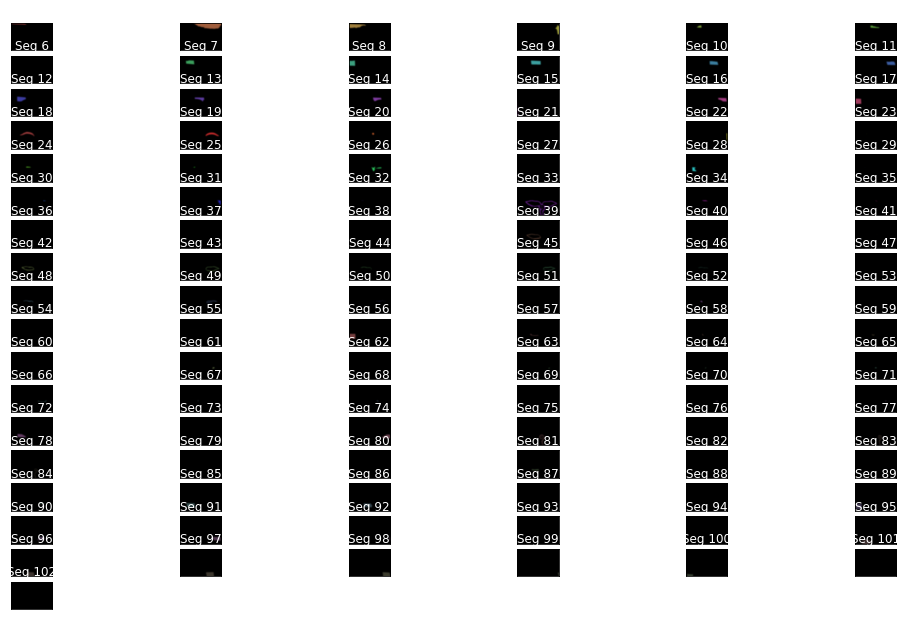

In [31]:
# Se compara con el .segment del ground truth
# el mismo se compone de una segmentacion humana

# Lectura del encabezado
estado = 0
header = 1
debug = 1
vector_img = []
segmento_img = []
fila_img = []
columna_img = []
with open(
    'ground-truth/56028-1130.seg'
    ) as fseg_humano:
    for linea in fseg_humano:
        linea = linea.replace('\n','')
        a = linea.split(' ')
        if header == 1:
            if (a[0] == 'width'):
                largo_img = int(a[1])
            if (a[0] == 'height'):
                alto_img = int(a[1])
            if (a[0] == 'segments'):
                segs_img = int(a[1])
            if (a[0] == 'data'):
                #segmentos = np.empty((segs_img, largo_img, alto_img), np.uint16)
                header = 0
        else:
            # lectura de los segmentos
            vector_img.append([[int(a[0]), int(a[1]), c] for c in np.arange(
                    int(a[2]),
                    int(a[3])
                    )])
            # 
            for c in np.arange(int(a[2]),int(a[3])):
                segmento_img.append(int(a[0]))
                fila_img.append(int(a[1]))
                columna_img.append(c)

colores = {
    '0': [0, 160, 160],
    '1': [10, 160, 160],
    '2': [20, 160, 160],
    '3': [30, 160, 160],
    '4': [40, 160, 160],
    '5': [50, 160, 160],
    '6': [60, 160, 160],
    '7': [70, 160, 160],
    '8': [80, 160, 160],
    '9': [90, 160, 160],
    '10': [100, 160, 160],
    '11': [110, 160, 160],
    '12': [120, 160, 160],
    '13': [130, 160, 160],
    '14': [140, 160, 160],
    '15': [150, 160, 160],
    '16': [160, 160, 160],
    '17': [170, 160, 160],
    '18': [180, 160, 160],
    '19': [0, 200, 200],
    '20': [10, 200, 200],
    '21': [20, 200, 200],
    '22': [30, 200, 200],
    '23': [40, 200, 200],
    '24': [50, 200, 200],
    '25': [60, 200, 200],
    '26': [70, 200, 200],
    '27': [80, 200, 200],
    '28': [90, 200, 200],
    '29': [100, 200, 200],
    '30': [110, 200, 200],
    '31': [120, 200, 200],
    '32': [130, 200, 200],
    '33': [140, 200, 200],
    '34': [150, 200, 200],
    '35': [160, 200, 200],
    '36': [170, 200, 200],
    '37': [180, 200, 200],
    '38': [0, 120, 120],
    '39': [10, 120, 120],
    '40': [20, 120, 120],
    '41': [30, 120, 120],
    '42': [40, 120, 120],
    '43': [50, 120, 120],
    '44': [60, 120, 120],
    '45': [70, 120, 120],
    '46': [80, 120, 120],
    '47': [90, 120, 120],
    '48': [100, 120, 120],
    '49': [110, 120, 120],
    '50': [120, 120, 120],
    '51': [130, 120, 120],
    '52': [140, 120, 120],
    '53': [150, 120, 120],
    '54': [160, 120, 120],
    '55': [170, 120, 120],
    '56': [180, 120, 120],
    '57': [0, 100, 100],
    '58': [10, 100, 100],
    '59': [20, 100, 100],
    '60': [30, 100, 100],
    '61': [40, 100, 100],
    '62': [50, 100, 100],
    '63': [60, 100, 100],
    '64': [70, 100, 100],
    '65': [80, 100, 100],
    '66': [90, 100, 100],
    '67': [100, 100, 100],
    '68': [110, 100, 100],
    '69': [120, 100, 100],
    '70': [130, 100, 100],
    '71': [140, 100, 100],
    '72': [150, 100, 100],
    '73': [160, 100, 100],
    '74': [170, 100, 100],
    '75': [180, 100, 100],
    '76': [0, 80, 80],
    '77': [10, 80, 80],
    '78': [20, 80, 80],
    '79': [30, 80, 80],
    '80': [40, 80, 80],
    '81': [50, 80, 80],
    '82': [60, 80, 80],
    '83': [70, 80, 80],
    '84': [80, 80, 80],
    '85': [90, 80, 80],
    '86': [100, 80, 80],
    '87': [110, 80, 80],
    '88': [120, 80, 80],
    '89': [130, 80, 80],
    '90': [140, 80, 80],
    '91': [150, 80, 80],
    '92': [160, 80, 80],
    '93': [170, 80, 80],
    '94': [180, 80, 80],
    '95': [0, 60, 60],
    '96': [10, 60, 60],
    '97': [20, 60, 60],
    '98': [30, 60, 60],
    '99': [40, 60, 60],
    '100': [50, 60, 60],
    '101': [60, 60, 60],
    '102': [70, 60, 60],
    '103': [80, 60, 60],
    '104': [90, 60, 60],
    '105': [100, 60, 60],
    '106': [110, 60, 60],
    '107': [120, 60, 60],
    '108': [130, 60, 60],
    '109': [140, 60, 60],
    '110': [150, 60, 60],
    '111': [160, 60, 60],
    '112': [170, 60, 60],
    '113': [180, 60, 60],
}

# Se obtienen los segmentos para graficar
img_segmentada = np.zeros((alto_img,largo_img,3), np.uint8)
segmentos_gt_humano = np.zeros((alto_img,largo_img), np.uint8)
try:
    for a in vector_img:
        for b in a:
            img_segmentada[b[1],b[2]] = colores.get(str(b[0]), [150,200,200])
            segmentos_gt_humano[b[1]][b[2]] = str(b[0])
except Exception as e:
    print("{} error: {}".format(a,e))

# Se arma las mascaras para cada uno de los segmentos
segmentos_humano = np.zeros((segs_img,alto_img,largo_img,3), np.uint8)
try:
    for a in vector_img:
        for b in a:
            segmentos_humano[b[0]][b[1],b[2]] = colores.get(str(b[0]), [150,200,200])
except Exception as e:
    print("{} error: {}".format(a,e))

# Se grafican los segmentos
fig = plt.figure(figsize=(18,12))
imagen_segmentos_humano = np.zeros((segs_img,alto_img,largo_img,3), np.uint8)
for a in range(len(segmentos_humano)):
    imagen_segmentos_humano[a] = cv2.cvtColor(segmentos_humano[a], cv2.COLOR_HSV2RGB)
    plt.subplot(20,6,a+1),plt.imshow(imagen_segmentos_humano[a], interpolation = 'bicubic')
    plt.subplots_adjust(wspace=0.05)
    plt.title("Seg {}".format(a),color="white")
    plt.xticks([]),plt.yticks([])

plt.show()